In [304]:
import pandas as pd

file_path = r'C:\Users\diwas\forexExport_From_2000-01-01_To_2025-04-18.csv'
df = pd.read_csv(file_path)

usd_rates = df[['Date', 'usd_buy', 'usd_sell']].copy()

# Round to 4 decimal places
usd_rates['Close'] = ((usd_rates['usd_buy'] + usd_rates['usd_sell']) / 2).round(4)

usd_real_rate = usd_rates[['Date', 'Close']]

output_path = r'C:\Users\diwas\USD_Real_Forex_Rate.csv'
usd_real_rate.to_csv(output_path, index=False)

print("✅ Done! Rounded forex rates saved at:", output_path)


✅ Done! Rounded forex rates saved at: C:\Users\diwas\USD_Real_Forex_Rate.csv


In [305]:
import pandas as pd

def read_df(csv_file):
    df = pd.read_csv(csv_file)
    
    # Try to convert, even with odd formats
    df["Date"] = pd.to_datetime(df["Date"], errors='coerce')  # This avoids crashing
    
    # Drop any rows where the date couldn't be parsed
    df.dropna(subset=["Date"], inplace=True)
    
    df.index = df["Date"]
    df.drop("Date", axis=1, inplace=True)
    
    df = df.filter(['Close'])
    
    return df

csv_file = r"C:\Users\diwas\USD_Real_Forex_Rate.csv"
df = read_df(csv_file)
df

,Close
Date,
2000-01-01,68.725
2000-01-02,68.725
2000-01-03,68.725
2000-01-04,68.725
2000-01-05,68.725
...,...
2025-04-14,137.670
2025-04-15,137.670
2025-04-16,137.240


In [2]:
pip install tensorflow


  Using cached tensorflow-2.19.0-cp312-cp312-win_amd64.whl.metadata (4.1 kB)
  Using cached absl_py-2.2.2-py3-none-any.whl.metadata (2.6 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached termcolor-3.0.1-py3-none-any.whl.metadata (6.1 kB)
  Using cached grpcio-1.71.0-cp312-cp312-win_amd64.whl.metadata (4.0 kB)
  Using cached tensorboard-2.19.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached keras-3.9.2-py3-none-any.whl.metadata (6.1 kB)
  Using cached ml_dtypes-0.5.1-cp312-cp312-win_amd64.whl.metadata (22 kB)
  Using cached namex-0.0.8-py3-none-any.whl.metadata (246 bytes)
  Using cached optree-0.1

In [306]:
import math
import numpy as np
import pandas as pd
from datetime import date, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

In [307]:
def plot_data(df):
    plt.figure(figsize=(16,8))
    plt.title("Close Price History")
    plt.plot(df['Close'])
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.show()

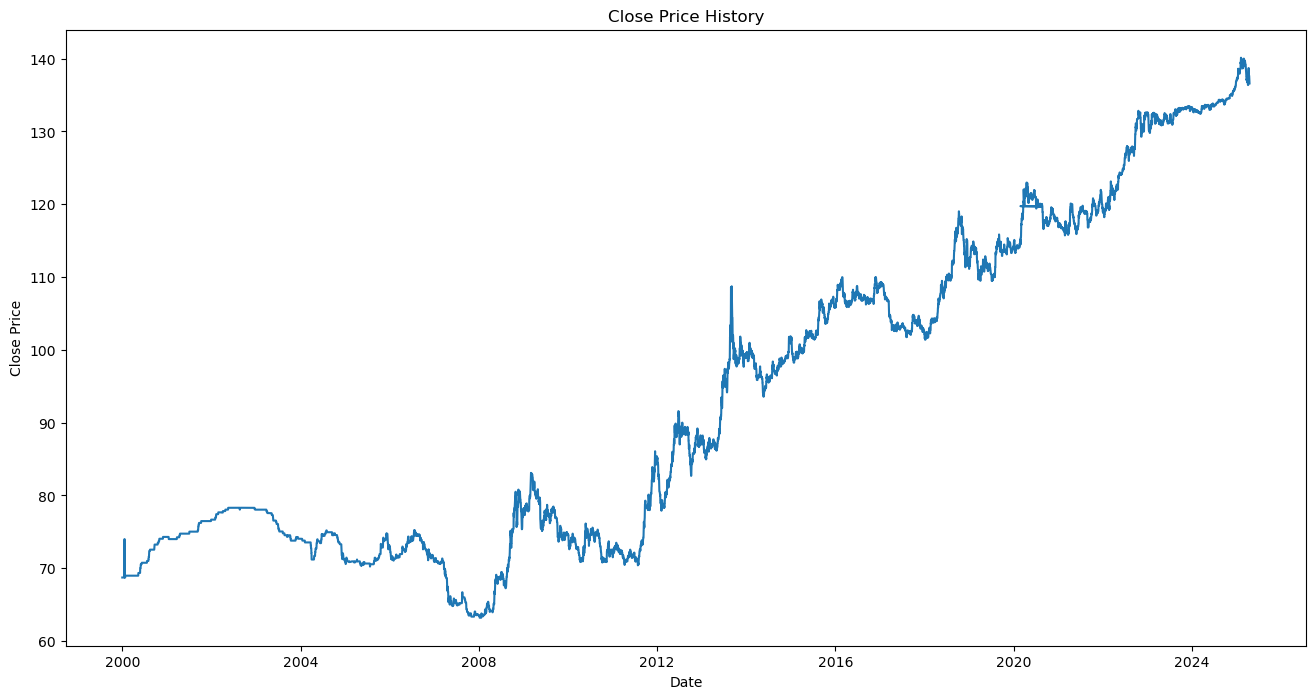

In [308]:
plot_data(df)

In [309]:
def train_test_split(df):
    sequence_length = 100
    split_index = math.ceil(len(df)*0.8)
    train_df = df.iloc[0:split_index, :]
    test_df = df.iloc[split_index - sequence_length:, :]
    return train_df, test_df, split_index
    

In [310]:
train_data, test_data, split = train_test_split(df)
test_data

,Close
Date,
2019-12-24,113.89
2019-12-25,113.80
2019-12-26,114.03
2019-12-27,114.10
2019-12-28,114.18
...,...
2025-04-14,137.67
2025-04-15,137.67
2025-04-16,137.24


In [311]:
def preprocess_data(data):
    nrows=data.shape[0]
    
    np_data_unscaled = np.array(data)
    np_data = np.reshape(np_data_unscaled, (nrows, -1))
    print(np_data.shape)

    scaler = MinMaxScaler()
    np_data_scaled = scaler.fit_transform(np_data_unscaled)

    return np_data_scaled, scaler

train_data_scaled, scaler = preprocess_data(train_data)
test_data_scaled, scaler = preprocess_data(test_data)
    

(7370, 1)
(1942, 1)


In [312]:
def partition_dataset(sequence_length, data):
    x, y =[], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:])
        y.append(data[i])

    x=np.array(x)
    y=np.array(y)
    return x, y

In [313]:
sequence_length = 100
x_train, y_train = partition_dataset(sequence_length, train_data_scaled)
x_test, y_test = partition_dataset(sequence_length, test_data_scaled)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(7270, 100, 1) (7270, 1)
(1842, 100, 1) (1842, 1)


In [315]:
model = Sequential()
model.add(LSTM(units=50, activation='relu', return_sequences= True, input_shape = (x_train.shape[1],1)))

model.add(Dropout(0.2))

model.add(LSTM(units=60, activation='relu',return_sequences=True))

model.add(Dropout(0.3))

model.add(LSTM(units=80, activation='relu', return_sequences = True))
model.add(Dropout(0.4))

model.add(LSTM(units=120, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [316]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                  │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 100, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 100, 60)        │        26,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 100, 60)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 100, 80)        │        45,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 100, 80)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 120)            │        96,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │           121 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,761 (698.29 KB)

 Trainable params: 178,761 (698.29 KB)

 Non-trainable params: 0 (0.00 B)

In [317]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, mode='min')

# Train the model
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop]
)

tf.keras.models.save_model(
    model,
    filepath ='model\\my_modeluni.h5',
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None,
    save_traces=True
)

Epoch 1/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 68s 257ms/step - loss: 0.0379 - val_loss: 0.0021
Epoch 2/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 59s 257ms/step - loss: 0.0053 - val_loss: 0.0046
Epoch 3/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 69s 303ms/step - loss: 0.0039 - val_loss: 0.0019
Epoch 4/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 80s 295ms/step - loss: 0.0034 - val_loss: 0.0017
Epoch 5/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 81s 290ms/step - loss: 0.0029 - val_loss: 0.0047
Epoch 6/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 68s 300ms/step - loss: 0.0027 - val_loss: 0.0057
Epoch 7/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 84s 307ms/step - loss: 0.0027 - val_loss: 0.0017
Epoch 8/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 83s 310ms/step - loss: 0.0027 - val_loss: 0.0015
Epoch 9/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 77s 288ms/step - loss: 0.0022 - val_loss: 0.0030
Epoch 10/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 67s 292ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 11/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 70s 308ms/step - loss: 0.0020 - val_loss: 0.0048
Epoch 12/50
228/228

ValueError: The following argument(s) are not supported: ['signatures', 'options', 'save_traces']

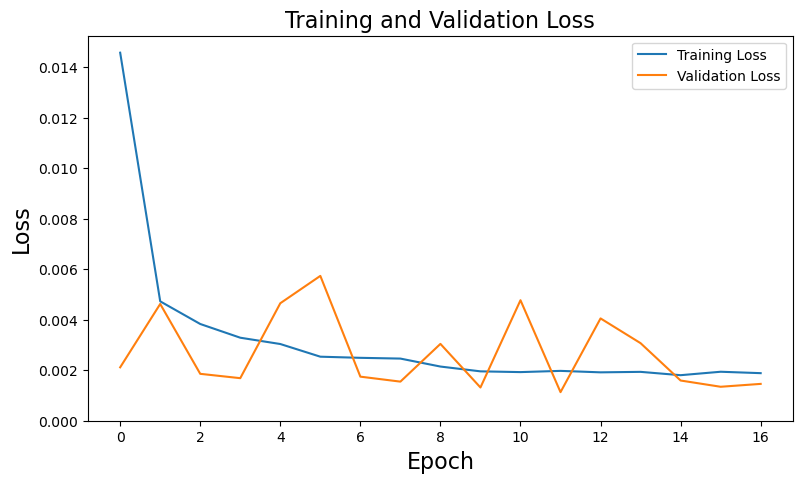

In [318]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend(loc="upper right")
plt.xlabel("Epoch", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.ylim([0, max(plt.ylim())])
plt.title("Training and Validation Loss", fontsize=16)
plt.show()

In [319]:
train_predict=model.predict(x_train)
test_predict=model.predict(x_test)
test_predict.shape

228/228 ━━━━━━━━━━━━━━━━━━━━ 24s 103ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step


(1842, 1)

In [320]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)
y_test_unscaled=scaler.inverse_transform(y_test.reshape(-1,1))

In [321]:
RMSE=math.sqrt(mean_squared_error(y_test_unscaled,test_predict))
print(f'Root Mean Square Error(RMSE): {np.round(RMSE, 2)}')

MAE = mean_absolute_error(y_test_unscaled, test_predict)
print(f'Mean Absolute Error(MAE): {np.round(MAE, 2)}')

MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, test_predict)/y_test_unscaled)))*100
print(f'Mean Absolute Percentage Error(MAPE): {np.round(MAPE, 2)}%')

MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, test_predict)/y_test_unscaled)))*100
print(f'Median Absolute Percentage Error(MAPE): {np.round(MDAPE, 2)}%')

Root Mean Square Error(RMSE): 1.02
Mean Absolute Error(MAE): 0.87
Mean Absolute Percentage Error(MAPE): 0.69%
Median Absolute Percentage Error(MAPE): 0.61%


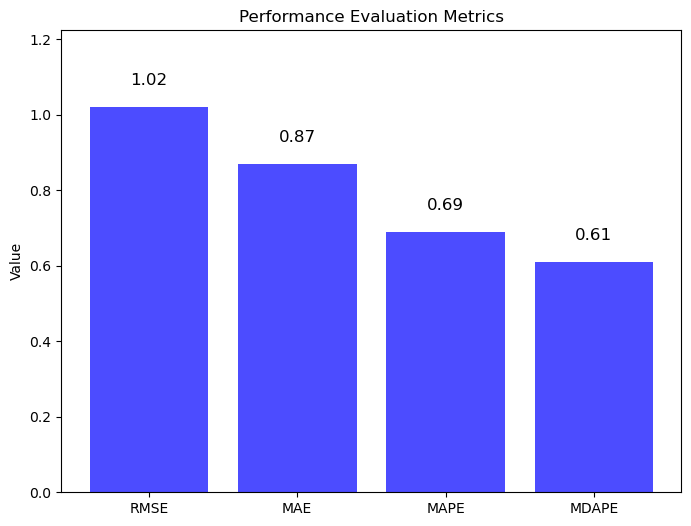

In [322]:
import matplotlib.pyplot as plt

metrics = ["RMSE", "MAE", "MAPE", "MDAPE"]
values = [1.02, 0.87, 0.69, 0.61]

plt.figure(figsize=(8,6))
plt.bar(metrics, values, color='blue', alpha=0.7)
plt.title('Performance Evaluation Metrics')
plt.ylabel('Value')
plt.ylim(0, max(values)*1.2)

# Add value labels on top of the bars
for i, value in enumerate(values):
    plt.text(i, value + 0.05, f"{value:.2f}", ha='center', va='bottom', fontsize=12)

plt.show()


In [324]:
Train = df[:split]
valid = df[split:]
valid['Predictions'] = test_predict
valid

C:\Users\diwas\AppData\Local\Temp\ipykernel_11444\925727386.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = test_predict


,Close,Predictions
Date,,
2020-04-02,120.90,120.300430
2020-04-03,120.90,120.345695
2020-04-04,121.88,120.379990
2020-04-05,121.88,120.409416
2020-04-06,121.98,120.440453
...,...,...
2025-04-14,137.67,136.062561
2025-04-15,137.67,136.134827
2025-04-16,137.24,136.210388


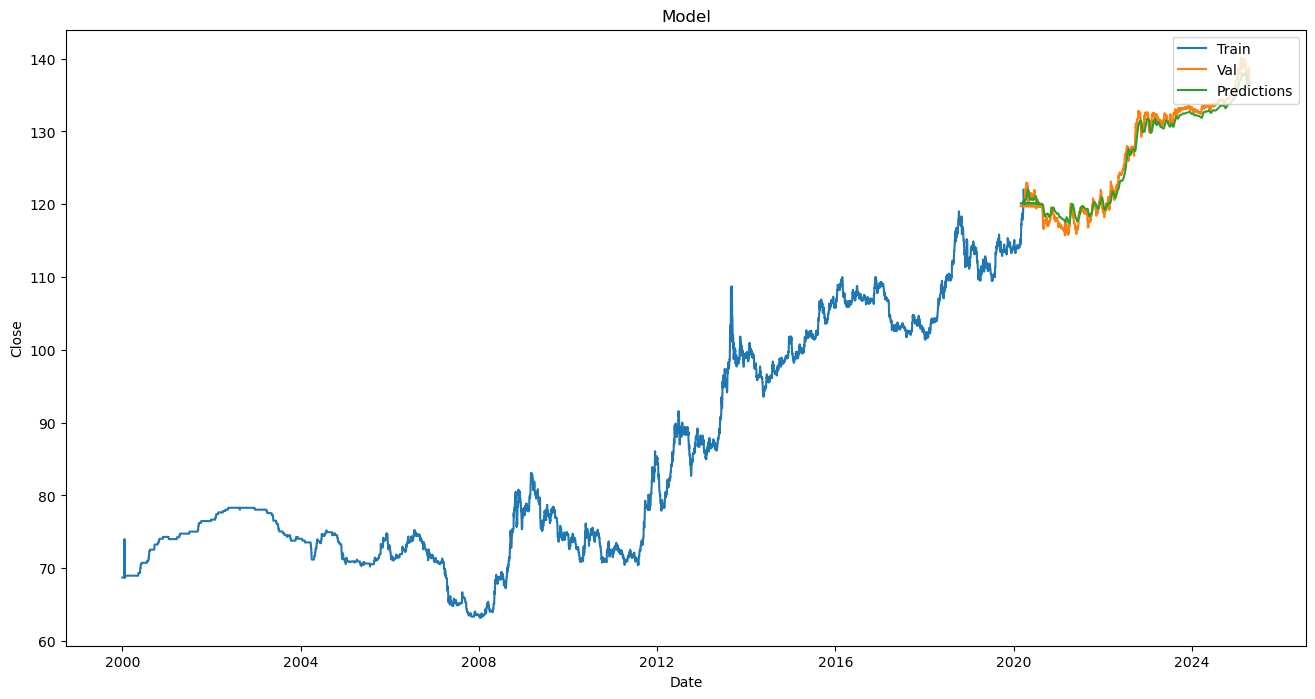

In [325]:
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close')

plt.plot(Train['Close'])
plt.plot(valid['Close'])
plt.plot(valid['Predictions'])

plt.legend(['Train', 'Val', 'Predictions'], loc='upper right')

plt.show()

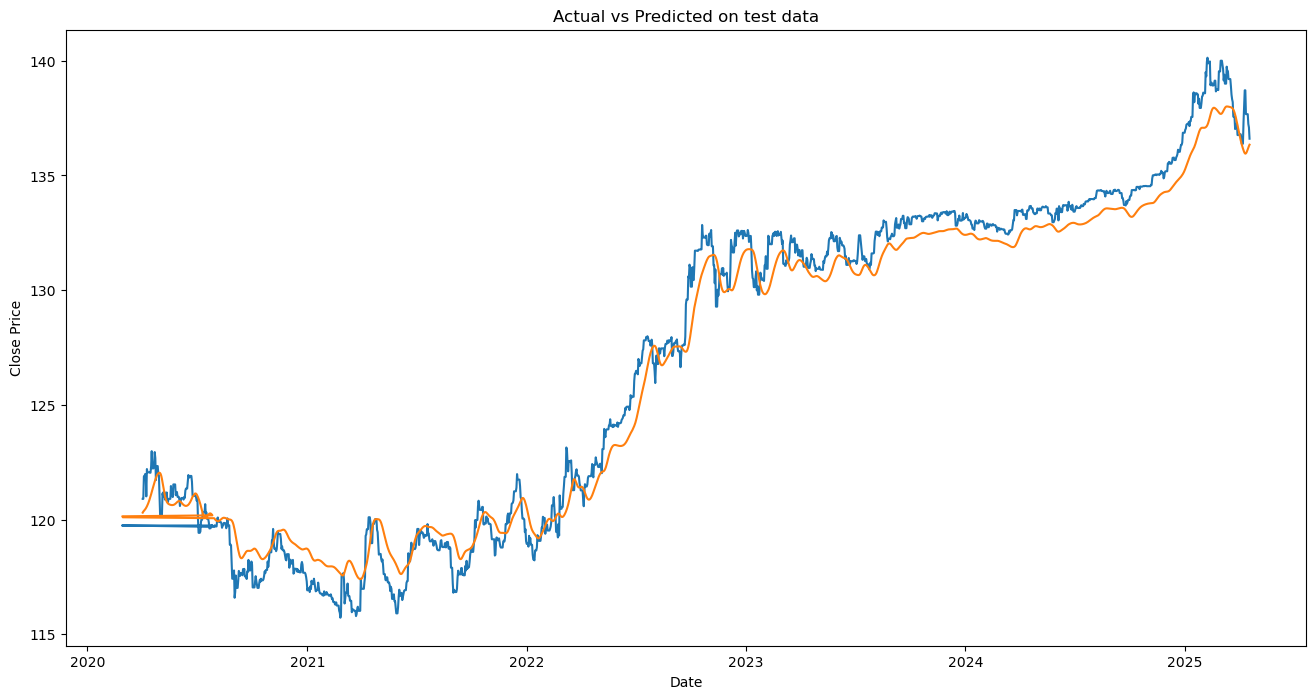

In [329]:
plt.figure(figsize=(16,8))
plt.title("Actual vs Predicted on test data")
plt.plot(valid['Close'])
plt.plot(valid['Predictions'])
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

C:\Users\diwas\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


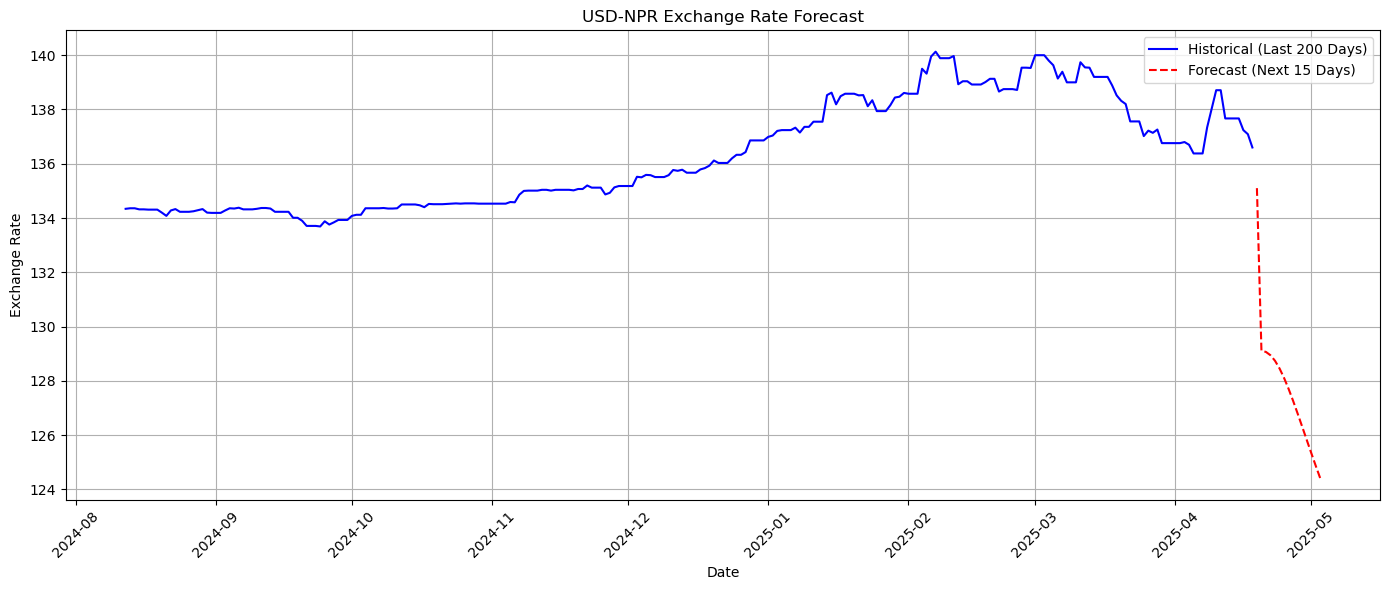

            Predicted Close
2025-04-19       135.101364
2025-04-20       129.113190
2025-04-21       129.065948
2025-04-22       128.943985
2025-04-23       128.740082
2025-04-24       128.457809
2025-04-25       128.108231
2025-04-26       127.705322
2025-04-27       127.263466
2025-04-28       126.796059
2025-04-29       126.314659
2025-04-30       125.828949
2025-05-01       125.346153
2025-05-02       124.871269
2025-05-03       124.407631


In [358]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model

# === Configuration ===
sequence_length = 250
forecast_days = 15

# === Prepare Scaler from Training Data ===
train_df = df.iloc[:int(len(df) * 0.8)]
scaler = MinMaxScaler()
scaler.fit(train_df[['Close']])  # Fit only on training portion

# === Scale Full Data ===
data_scaled = scaler.transform(df[['Close']])
x_input = data_scaled[-sequence_length:].reshape(1, sequence_length, 1)


# === Forecasting with First-Day Blending Only ===
predictions_scaled = []
last_close = df['Close'].iloc[-1]

for i in range(forecast_days):
    yhat = model.predict(x_input, verbose=0)

    if i == 0:
        # Blend first prediction with last actual close (80% real, 20% predicted)
        yhat_unscaled = scaler.inverse_transform([[yhat[0][0]]])[0][0]
        yhat_blended = 0.8 * last_close + 0.2 * yhat_unscaled
        yhat[0][0] = scaler.transform([[yhat_blended]])[0][0]

    predictions_scaled.append(yhat[0][0])
    x_input = np.concatenate((x_input[:, 1:, :], yhat.reshape(1, 1, 1)), axis=1)

# === Inverse Transform Predictions ===
predicted_values = scaler.inverse_transform(np.array(predictions_scaled).reshape(-1, 1))

# === Build Forecast DataFrame ===
forecast_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=forecast_days)
forecast_df = pd.DataFrame({'Predicted Close': predicted_values.flatten()}, index=forecast_index)

# === Plot: Last 200 Days + Forecast ===
plt.figure(figsize=(14, 6))
plt.plot(df.index[-sequence_length:], df['Close'].iloc[-sequence_length:], label='Historical (Last 200 Days)', color='blue')
plt.plot(forecast_df.index, forecast_df['Predicted Close'], label='Forecast (Next 15 Days)', color='red', linestyle='--')

plt.title('USD-NPR Exchange Rate Forecast')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Preview the forecasted values
print(forecast_df)


In [359]:
forecast_df

,Predicted Close
2025-04-19,135.101364
2025-04-20,129.113190
2025-04-21,129.065948
2025-04-22,128.943985
2025-04-23,128.740082
2025-04-24,128.457809
2025-04-25,128.108231
2025-04-26,127.705322
2025-04-27,127.263466
2025-04-28,126.796059


TensorFlow is working! ✅
2.19.0
